# Forecasting Daily Data using Facebook Prophet

**In this practical you will learn:**

* How to wrangle time series data into `Prophet` format
* How to fit a `Prophet` model to a time series
* How to obtain a point forecast and prediction intervals using `Prophet`
* How to model special calender events.
* How to use `Prophet`'s built in diagnostic and cross validation tools

---

## Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## FB Prophet Imports

If you are using the provided conda environment `hsma4_forecast9b` you will already have `prophet` installed.  

In [2]:
from prophet import Prophet

import prophet

# should be version 1.0
prophet.__version__

'1.0'

## forecast-tools imports

In [3]:
# uncomment if you need to install forecast-tools
#!pip install forecast-tools

In [4]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import mean_absolute_error

# Data - ED reattendances

We will use an time series of patients that reattend an ED within 7 days.  The data are held at the **daily** level.

The data is held in the file `ed_reattends_day.csv`

# Exercise 1: Read in and adjust

**Task:**

* Load `ed_reattends_day.csv` (url provided below)
* Plot the data
* Name the `pd.DataFrame` you create `y_train`

**Hints**

* The data is stored in UK day first format.
* Remember to set the freq of the DataTimeIndex

**Questions**:
* How would you describe the time series?

In [5]:
# your code here ...
url = 'https://raw.githubusercontent.com/hsma5/9b_forecasting_with_prophet/' \
      + 'main/data/ed_reattends_day.csv'

In [6]:
# example solution

y_train = pd.read_csv(url, parse_dates=True, 
                            dayfirst=True, index_col='date')
y_train.index.freq = 'D'

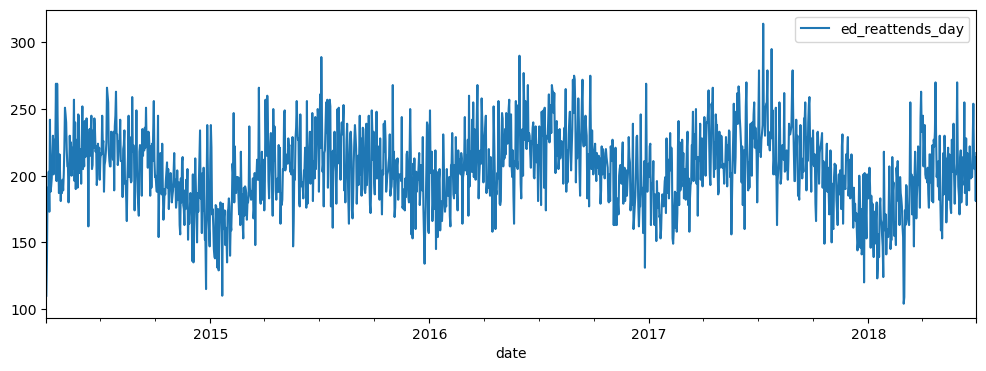

In [7]:
_ = y_train.plot(figsize=(12,4))

# Exercise 2: Wrangle the data into Prophet Format

A `Prophet` model requires the data in a `pd.DataFrame` with two columns: 'ds' - the datetimestamp and `y` the observations used in training (the index is an arbitrary numeric value).  But your current (and standard form) dataframe has a datetimeindex 

**Task:**

* Code a function that converts the training data into the correct format for Prophet.
* The end product should be a dataframe with 2 columns (in the following order)
 * 'ds': the date
 * 'y': the number of reattends on that day.
* Convert your data

In [8]:
# your code goes here...

In [9]:
#example solution

def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

In [10]:
yp_train = prophet_training_data(y_train)

In [11]:
yp_train.head()

,ds,y
0,2014-04-03,110.0
1,2014-04-04,138.0
2,2014-04-05,191.0
3,2014-04-06,176.0
4,2014-04-07,203.0


# Exercise 3: Fit and predict using a basic Prophet model

Fitting a basic Prophet model is relatively straightforward.  We need to create a `Prophet` object

```python
model = Prophet()
```
Unlike our naive forecasting where we specified the prediction interval width at prediction time, with Prophet we need to specify the interval width as we create the model.  We do this using the parameter `interval_width`.  By default this produces a 80\% prediction interval.  Note we specify a $1-\alpha$ interval width (unlike in our naive models where we specified $\alpha$)

```python
model = Prophet(interval_width=0.95)
```

and call `.fit()` passing in the training data.

```python
model.fit(y_train)
```

## Exercise 3.1 Fitting
**Task:**

* Fit a basic `Prophet` model to the training data
* Set the model up to produce 95\% prediction intervals

> You might find that Prophet warns you that it has disabled **daily seasonality**.  This is slightly confusing terminology.  What it means is that it is not fitting intra-day, e.g. hourly, seasonality.

In [12]:
# your code here ...

In [60]:
#example solution
model = Prophet(interval_width=0.95,
               daily_seasonality=True)
model.fit(yp_train)

Initial log joint probability = -43.3254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3337.68   0.000905608       90.1378      0.5249      0.5249      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       3339.57   2.37275e-05       36.4259    4.24e-07       0.001      289  LS failed, Hessian reset 
     199       3339.58   9.50687e-06       35.0096      0.2067           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       3339.63   5.75383e-05       71.8095   1.104e-06       0.001      402  LS failed, Hessian reset 
     279       3339.64   4.30496e-06       60.7351   8.436e-08       0.001      502  LS failed, Hessian reset 
     299       3339.64   2.00662e-05       50.2076           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

# Exercise 3.2 Forecasting

There are two steps to makeing a forecast with a fitted `Prophet` model.  You must first create a future dataframe.  This is a `pd.DataFrame` with a single column 'ds' that runs from the start of the training period until the end of the training period + a horizon.  Prophet makes this easy by including a `make_future_dataframe()` method.

```python
future = model.make_future_dataframe(periods=28)
```

Once we have the future dataframe we can pass that to the predict method.

```python
prophet_forecast = model.predict(future)
```

This returns a `pd.DataFrame` that contains both the in-sample fitted values and the out of sample forecasts. It contains all of the components of the fitted model. For example the last 5 rows of a forecast are:

|      | ds                  |   trend |   yhat_lower |   yhat_upper |   trend_lower |   trend_upper |   additive_terms |   additive_terms_lower |   additive_terms_upper |    weekly |   weekly_lower |   weekly_upper |   yearly |   yearly_lower |   yearly_upper |   multiplicative_terms |   multiplicative_terms_lower |   multiplicative_terms_upper |    yhat |
|-----:|:--------------------|--------:|-------------:|-------------:|--------------:|--------------:|-----------------:|-----------------------:|-----------------------:|----------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------------:|-----------------------------:|--------:|
| 1629 | 2018-09-18 00:00:00 | 187.353 |      163.694 |      236.271 |       186.22  |       188.383 |        11.0807   |              11.0807   |              11.0807   |  -2.83494 |       -2.83494 |       -2.83494 |  13.9156 |        13.9156 |        13.9156 |                      0 |                            0 |                            0 | 198.433 |
| 1630 | 2018-09-19 00:00:00 | 187.305 |      157.7   |      226.979 |       186.153 |       188.356 |         5.91039  |               5.91039  |               5.91039  |  -7.49286 |       -7.49286 |       -7.49286 |  13.4032 |        13.4032 |        13.4032 |                      0 |                            0 |                            0 | 193.215 |
| 1631 | 2018-09-20 00:00:00 | 187.257 |      150.343 |      224.271 |       186.088 |       188.328 |         0.527382 |               0.527382 |               0.527382 | -12.3179  |      -12.3179  |      -12.3179  |  12.8452 |        12.8452 |        12.8452 |                      0 |                            0 |                            0 | 187.785 |
| 1632 | 2018-09-21 00:00:00 | 187.209 |      156.873 |      226.588 |       186.023 |       188.3   |         3.90459  |               3.90459  |               3.90459  |  -8.34281 |       -8.34281 |       -8.34281 |  12.2474 |        12.2474 |        12.2474 |                      0 |                            0 |                            0 | 191.114 |
| 1633 | 2018-09-22 00:00:00 | 187.162 |      169.299 |      241.272 |       185.954 |       188.272 |        15.9777   |              15.9777   |              15.9777   |   4.36149 |        4.36149 |        4.36149 |  11.6162 |        11.6162 |        11.6162 |                      0 |                            0 |                            0 | 203.139 |


We can the plot the forecast using Prophet's built in functionality

```python
model.plot(prophet_forecast);
```

In the plot you will see

* Black dots - these represent the actual observations (training data)
* Blue line - this represents the point forecast
* Light blue shaded region - this is the 95\% prediction interval

**Task:**
* Use your Prophet model to make a 84 day prediction.
* Plot the prediction

In [14]:
# your code here ...

In [15]:
#example solution
future = model.make_future_dataframe(periods=84)
future

,ds
0,2014-04-03
1,2014-04-04
2,2014-04-05
3,2014-04-06
4,2014-04-07
...,...
1629,2018-09-18
1630,2018-09-19
1631,2018-09-20
1632,2018-09-21


In [16]:
prophet_forecast = model.predict(future)
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1629,2018-09-18,187.149799,160.589109,239.247243,186.364258,188.056117,12.039542,12.039542,12.039542,-2.057956,-2.057956,-2.057956,14.097498,14.097498,14.097498,0.0,0.0,0.0,199.189341
1630,2018-09-19,187.102053,150.350261,233.769243,186.304582,188.021831,5.651299,5.651299,5.651299,-7.972490,-7.972490,-7.972490,13.623789,13.623789,13.623789,0.0,0.0,0.0,192.753353
1631,2018-09-20,187.054308,146.052314,228.489438,186.244906,187.986909,1.302522,1.302522,1.302522,-11.807124,-11.807124,-11.807124,13.109646,13.109646,13.109646,0.0,0.0,0.0,188.356830
1632,2018-09-21,187.006563,149.503947,231.925189,186.179154,187.951631,4.154090,4.154090,4.154090,-8.407146,-8.407146,-8.407146,12.561236,12.561236,12.561236,0.0,0.0,0.0,191.160653
1633,2018-09-22,186.958818,161.998064,245.371646,186.120736,187.911228,15.432436,15.432436,15.432436,3.447387,3.447387,3.447387,11.985049,11.985049,11.985049,0.0,0.0,0.0,202.391254


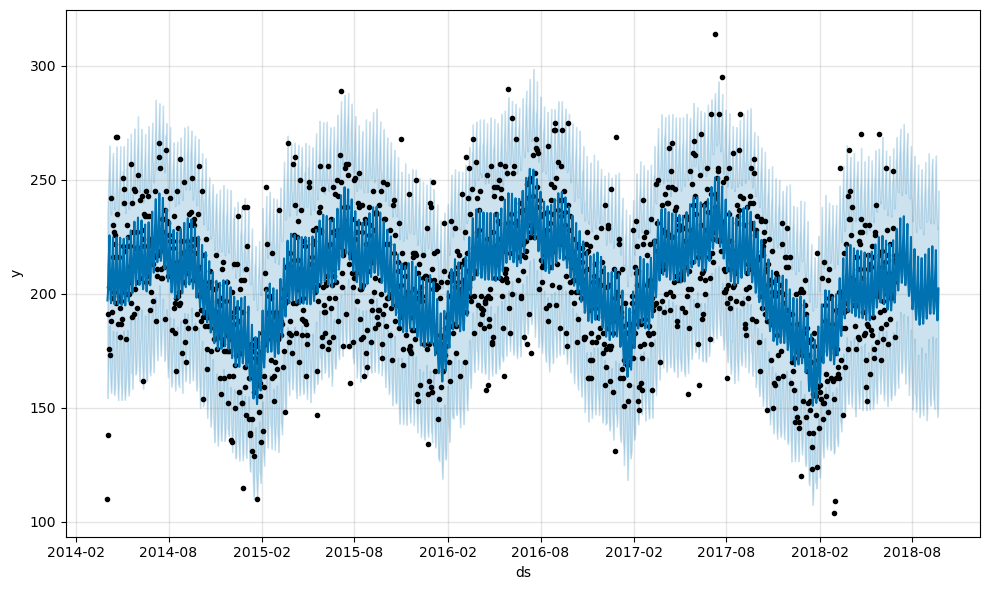

In [17]:
_ = model.plot(prophet_forecast)

# Exercise 4: Plot the model components

To decompose the Prophet model and see the trend and seasonal components you can call:

```python
model.plot_components(forecast)
```

**Task:**

* Plot the Prophet model's trend and seasonal components.


**Questions:**
* What observations can you make about the weekly (i.e. days of the week) and yearly (i.e months of the year) seasonality?

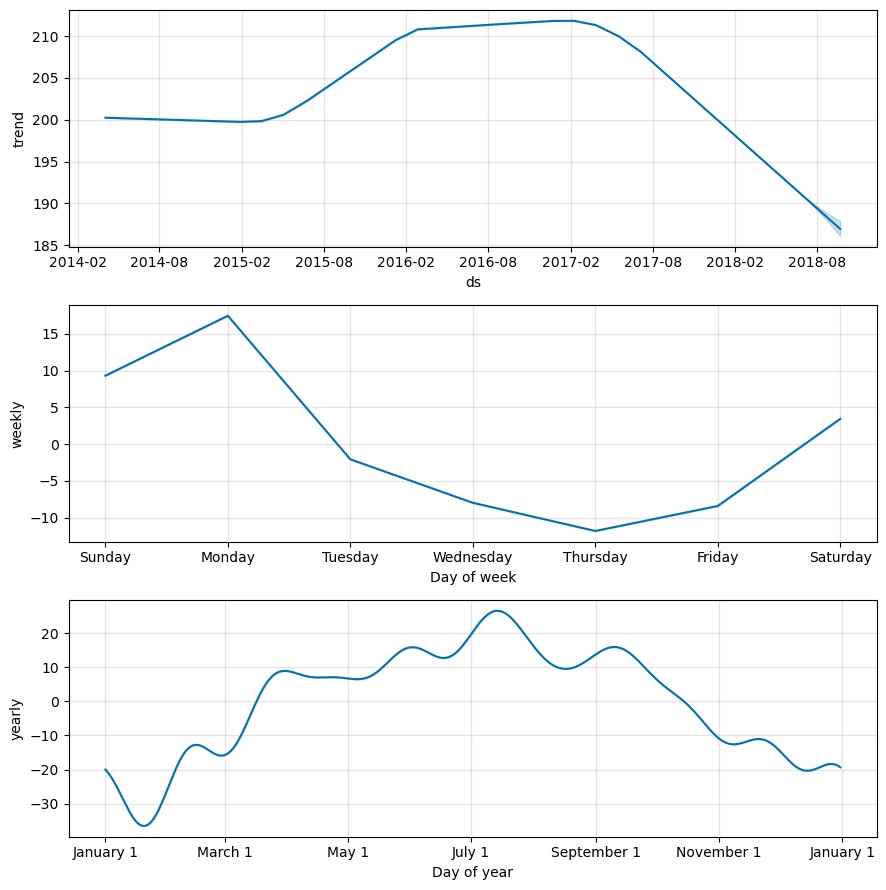

In [18]:
_ = model.plot_components(prophet_forecast)


# Exercise 5: Adding standard holidays

As this is ED reattendance data at the daily level, it is likely that we will be seeing some calender day/holiday effects.  Prophet has been designed to deal with 'holidays'.  Effectively a series of binary variables are added for each holiday.

Prophet has a number of standard holidays built in by country.  To add them in for 'England' you would use the following code:

```python
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='England')
model.fit(y_train)
```

Note that you call the `add_country_holidays` **before** you fit the model.  This is because it is command telling Prophet what you would like to fit.

To see what models have been fitted you can call:

```python
model.train_holiday_names.to_list()
```

When you plot the components of the model a new panel will be added for holidays.  It can sometimes be a bit difficult to which holidays are having which effect so you can plot individual holidays as follows:

```python
from fbprophet.plot import plot_forecast_component

plot_forecast_component(model, prophet_forecast, 'Christmas Day');
```

**Task:**

* Modify your code to include a holidays for 'England'
* Make an 84 day forecast
* Plot the model components. 
* Explore the holidays

**Questions:**

* What do you notice about Christmas day, Easter Monday and Good Friday?  Are there any other days that appear important?

**Hints:**
* Take a look at the new forecast dataframe.  This includes new columns with the effect of each `holidays`.

In [19]:
#your code here ...

In [20]:
# example solution
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='UK')
model.fit(yp_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -30.1068


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3452.53    0.00227493       89.8573      0.7815      0.7815      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       3455.74   0.000180872       93.8966   9.896e-07       0.001      266  LS failed, Hessian reset 
     199       3455.98    6.9353e-05       53.8845       1.216      0.3291      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3456.04   0.000215453       75.8124   3.197e-06       0.001      366  LS failed, Hessian reset 
     272       3456.07   8.40832e-08       62.6187     0.03855      0.4479      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [21]:
model.train_holiday_names.to_list()

["New Year's Day",
 'New Year Holiday [Scotland]',
 'New Year Holiday [Scotland] (Observed)',
 "St. Patrick's Day [Northern Ireland]",
 'Battle of the Boyne [Northern Ireland]',
 'Summer Bank Holiday [Scotland]',
 "St. Andrew's Day [Scotland]",
 'Christmas Day',
 'Christmas Day (Observed)',
 'Good Friday',
 'Easter Monday [England/Wales/Northern Ireland]',
 'May Day',
 'Spring Bank Holiday',
 'Late Summer Bank Holiday [England/Wales/Northern Ireland]',
 'Boxing Day',
 "New Year's Day (Observed)",
 "St. Patrick's Day [Northern Ireland] (Observed)",
 'Boxing Day (Observed)']

In [22]:
future = model.make_future_dataframe(periods=84)
prophet_forecast = model.predict(future)

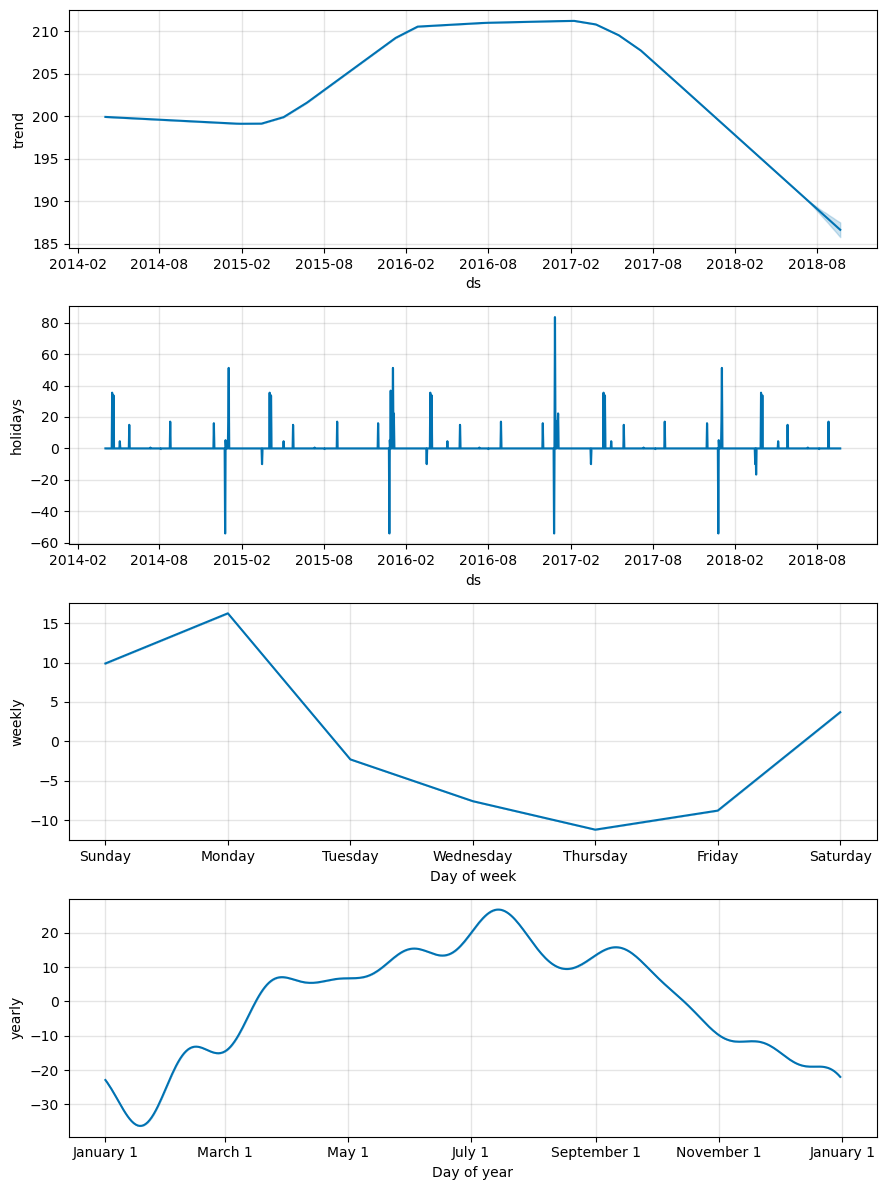

In [23]:
model.plot_components(prophet_forecast);

In [24]:
prophet_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Battle of the Boyne [Northern Ireland]',
       'Battle of the Boyne [Northern Ireland]_lower',
       'Battle of the Boyne [Northern Ireland]_upper', 'Boxing Day',
       'Boxing Day_lower', 'Boxing Day_upper', 'Boxing Day (Observed)',
       'Boxing Day (Observed)_lower', 'Boxing Day (Observed)_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper',
       'Easter Monday [England/Wales/Northern Ireland]',
       'Easter Monday [England/Wales/Northern Ireland]_lower',
       'Easter Monday [England/Wales/Northern Ireland]_upper', 'Good Friday',
       'Good Friday_lower', 'Good Friday_upper',
       'Late Summer Bank Holiday [England/Wales/Northern Ireland]',
       'Late Summer Bank Holiday [England/Wales/Northern Ireland]_lower',
       'Late Summer Bank Holiday [Eng

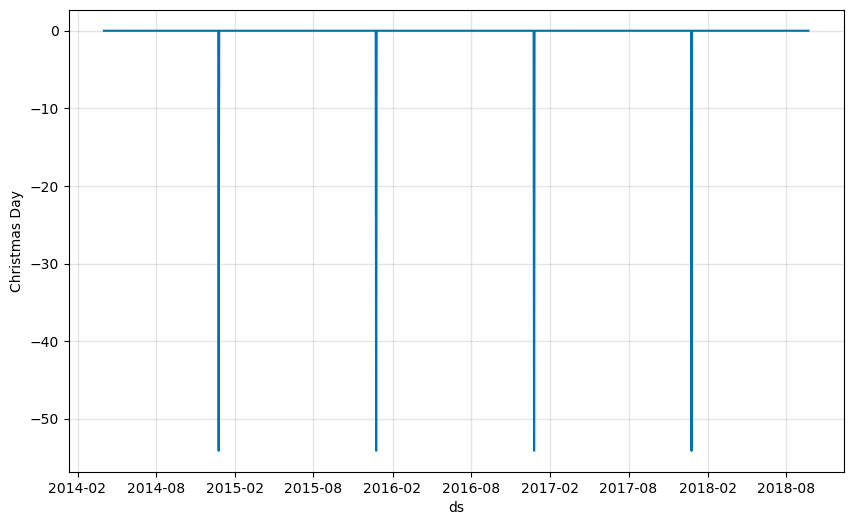

In [25]:
from prophet.plot import plot_forecast_component
plot_forecast_component(model, prophet_forecast, 'Christmas Day');

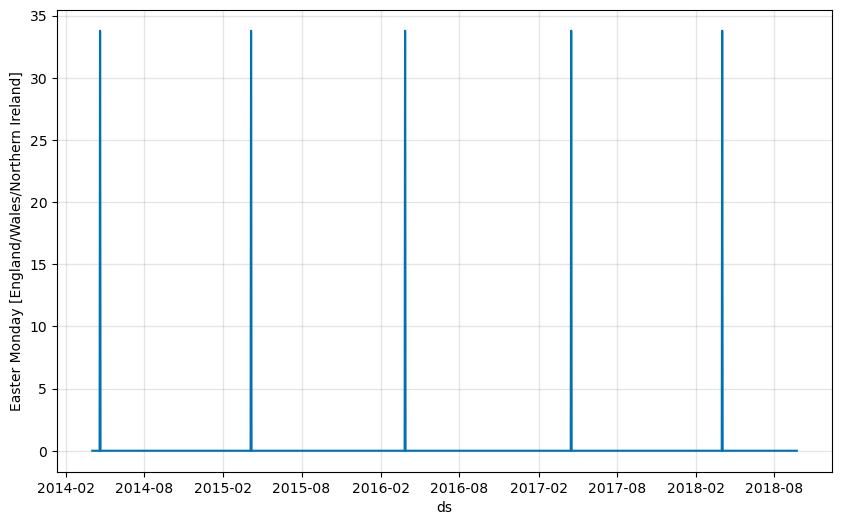

In [26]:
plot_forecast_component(model, prophet_forecast, 'Easter Monday [England/Wales/Northern Ireland]');

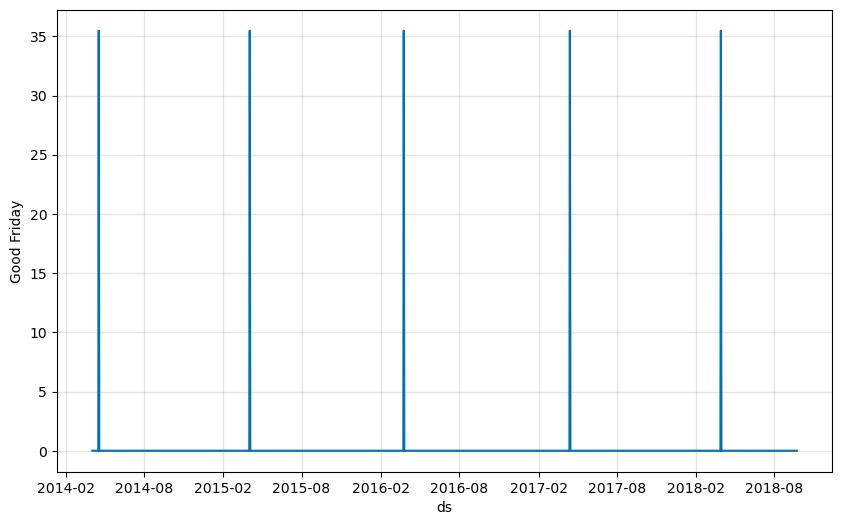

In [27]:
plot_forecast_component(model, prophet_forecast, 'Good Friday');

In [28]:
# Adding a day of month seasonality.

Initial log joint probability = -30.1068
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3456.15     0.0054277       165.003           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       3458.21    0.00020779       120.962   1.403e-06       0.001      251  LS failed, Hessian reset 
     199       3458.65   3.98487e-05       46.6658      0.1575      0.5934      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       3458.68   0.000103443        38.493   2.369e-06       0.001      350  LS failed, Hessian reset 
     243       3458.71   4.35562e-05       77.0036   8.797e-07       0.001      443  LS failed, Hessian reset 
     263       3458.72    6.6955e-08       42.7908     0.03738           1      479   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

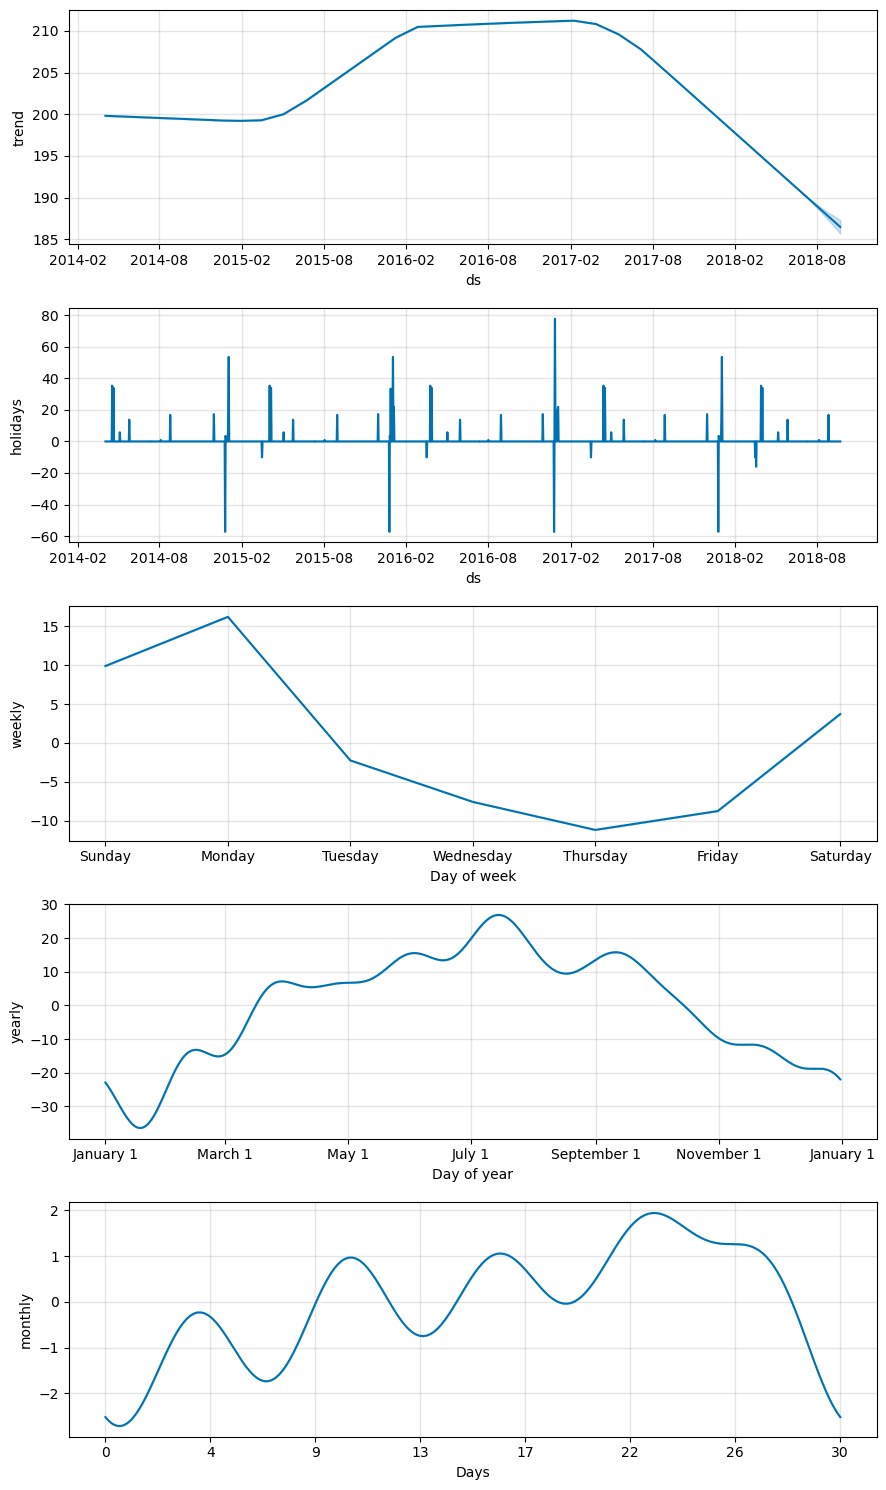

In [29]:
model = Prophet(interval_width=0.95, daily_seasonality=False)
model.add_country_holidays(country_name='UK')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(yp_train)
future = model.make_future_dataframe(periods=84)
prophet_forecast = model.predict(future)
_ = model.plot_components(prophet_forecast);

# END

In [30]:
y_train

,ed_reattends_day
date,
2014-04-03,110.0
2014-04-04,138.0
2014-04-05,191.0
2014-04-06,176.0
2014-04-07,203.0
...,...
2018-06-26,215.0
2018-06-27,205.0
2018-06-28,214.0


In [43]:
yp_train = prophet_training_data(y_train[:-28])
yp_test = prophet_training_data(y_train[-28:])

In [44]:
print(y_train.shape)
print(yp_train.shape)
print(yp_test.shape)

(1550, 1)
(1522, 2)
(28, 2)


In [45]:
import numpy as np
from forecast_tools.datasets import load_emergency_dept
from forecast_tools.model_selection import auto_naive 

In [46]:
best = auto_naive(y_train[:-28], horizon=28, seasonal_period=365)
best

{'model': EnsembleNaive(seasonal_period=365), 'mae': 22.111046812728627}

In [57]:
from forecast_tools.baseline import EnsembleNaive

ens = EnsembleNaive(365)
ens_preds = ens.fit_predict(y_train[:-28], horizon=28)

In [48]:
model = Prophet(interval_width=0.95, daily_seasonality=False)
model.add_country_holidays(country_name='UK')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(yp_train)
future = model.make_future_dataframe(periods=28)
prophet_forecast = model.predict(future)
#_ = model.plot_components(prophet_forecast);

Initial log joint probability = -43.3254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3391.51    0.00291603        79.801           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       3392.46   0.000186131       96.9934   2.417e-06       0.001      226  LS failed, Hessian reset 
     167       3392.73   7.92187e-05        56.205   1.435e-06       0.001      293  LS failed, Hessian reset 
     199       3392.77   0.000360175       58.6442      0.1441           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237        3392.8   2.49578e-05       45.2334   4.285e-07       0.001      427  LS failed, Hessian reset 
     246        3392.8   6.63086e-08       66.5431     0.01817     0.08192      443   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

In [58]:
from forecast_tools.metrics import forecast_errors # creates range of forecast errors
# below is forecast errors for SNaive
# ~12% error
forecast_errors(y_train[-28:], prophet_forecast['yhat'].iloc[-28:].to_list())

{'me': 3.271651699009377,
 'mae': 16.261380840126723,
 'mse': 445.1376758324366,
 'rmse': 21.098286087557838,
 'mape': 7.6855356720077,
 'smape': 7.783589714409902}

In [59]:
forecast_errors(y_train[-28:], ens_preds)

{'me': 16.605123177276464,
 'mae': 20.01722041093494,
 'mse': 662.3611781744199,
 'rmse': 25.736378497652307,
 'mape': 9.148254802426605,
 'smape': 9.769057253420412}